In [417]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve
import cv2

import matplotlib.pyplot as plt
from matplotlib import path

import os

%matplotlib inline

## 1 Select a grayscale image

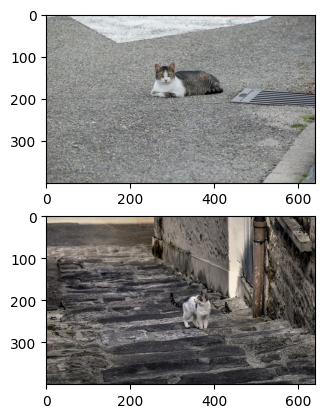

In [418]:
src_image = plt.imread('cat-road_640.jpg')
dst_image = plt.imread('cat-street_640.jpg')

#src_image = plt.imread('snow.jpg')
#dst_image = plt.imread('pine.jpg')

src_image = src_image.astype(np.float32) / 255.
dst_image = dst_image.astype(np.float32) / 255.

height, width, ch = src_image.shape

fig, ax = plt.subplots(2, 1)
ax[0].imshow(src_image)
ax[1].imshow(dst_image)

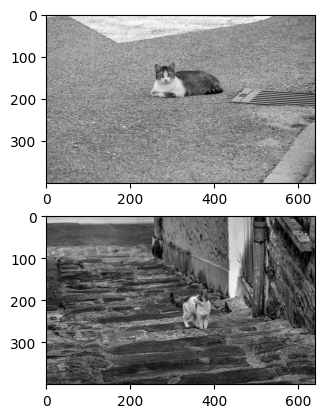

In [419]:
src_image_gray = np.mean(src_image, axis=2)
dst_image_gray = np.mean(dst_image, axis=2)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(src_image_gray, cmap='gray')
ax[1].imshow(dst_image_gray, cmap='gray')

In [420]:
def constructMaskImage(mask_arr, image_shape):
    mask = mask_arr.copy()
    mask[:, 0] = mask_arr[:, 1]
    mask[:, 1] = mask_arr[:, 0]
    mask_image = np.zeros(image_shape)
    mask_image = cv2.fillConvexPoly(mask_image, mask, 1.0)
    mask_image = mask_image.astype(np.int32)

    return mask_image

In [421]:
def readMaskImage(mask_path):
    mask_image = plt.imread(mask_path)
    mask_image = np.mean(mask_image, axis=2)
    threshold = np.mean(mask_image)
    mask_image01 = np.zeros(mask_image.shape)
    mask_image01[mask_image > threshold] = 1

    return mask_image01.astype(np.int32)

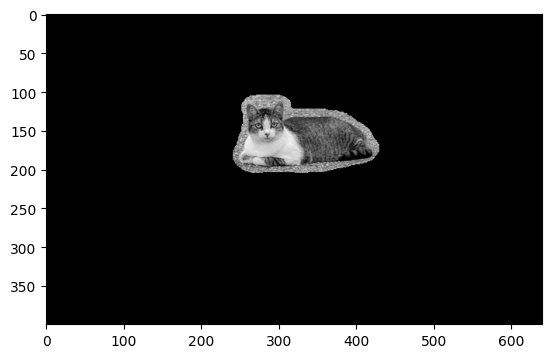

In [422]:
mask_rev1 = np.array([
    [100, 80],
    [80, 120],
    [100, 210],
    [290, 210],
    [280, 120],
    [270, 70],
    [150, 50]
])

mask_rev3 = np.array([
    [350, 270],
    [350, 300],
    [380, 320],
    [400, 250],
    [370, 240],
])

mask_rev2 = np.array([
    [30, 80],
    [20, 150],
    [40, 160],
    [70, 100],
    [50, 60],
])

mask_rev = np.array([
    [120, 230],
    [100, 270],
    [110, 420],
    [200, 430],
    [220, 260],
    [200, 230],
])
 
#mask_image = constructMaskImage(mask_rev, src_image_gray.shape)
mask_image = readMaskImage('mask.jpg')

masked_image = src_image_gray.copy().astype(np.float32)
masked_image *= mask_image.astype(np.float32)
plt.imshow(masked_image, cmap='gray')
plt.show()

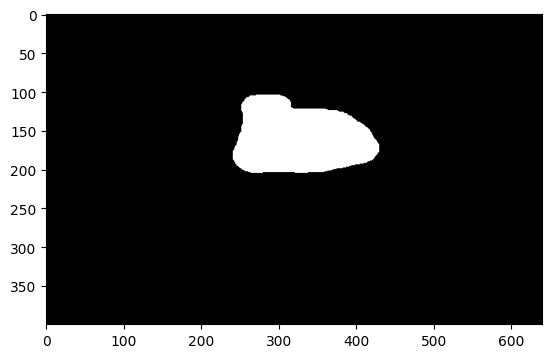

In [423]:
plt.imshow(mask_image, cmap='gray')
plt.show()

In [424]:
def atBoundary(pos, mask_image):
    i, j = pos
    height, width = mask_image.shape
    if not (0 <= i < height and 0 <= j < width):
        return False
    if mask_image[i, j] == 0:
        return False
    d = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]
    for h, w in d:
        if not (0 <= h < height and 0 <= w < width):
            return True
        if mask_image[h, w] == 0:
            return True
    return False 

def constructEqn1(src_image, mask_image, dst_image,  shift=(0, 0)):
    pixel_num = np.sum(mask_image)
    A = np.zeros((pixel_num, pixel_num))
    b = np.zeros((pixel_num,))
    idx = np.vstack(np.where(mask_image==1)).T
    idx_image = mask_image.copy()
    si, sj = shift
    for n, (i, j) in enumerate(idx):
        idx_image[i, j] = n
    for i, j in idx:
        n = idx_image[i, j]
        if atBoundary((i, j), mask_image):
            A[n, n] = 1
            b[n] = dst_image[i + si, j + sj]
        else:
            A[n, n] = 4
            d = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]
            for ni, nj in d:
                nn = idx_image[ni, nj]
                A[n, nn] = -1
    return A, b, idx

def constructSeamlessEqn1(src_image, mask_image, dst_image, shift=(0, 0)):
    pixel_num = np.sum(mask_image)
    A = np.zeros((pixel_num, pixel_num))
    b = np.zeros((pixel_num,))
    idx = np.vstack(np.where(mask_image==1)).T
    idx_image = mask_image.copy()
    si, sj = shift
    for n, (i, j) in enumerate(idx):
        idx_image[i, j] = n
    for i, j in idx:
        n = idx_image[i, j]
        if atBoundary((i, j), mask_image):
            A[n, n] = 1
            b[n] = dst_image[i + si, j + sj]
        else:
            A[n, n] = 4
            d = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]
            b[n] = 4 * src_image[i, j]
            for ni, nj in d:
                nn = idx_image[ni, nj]
                A[n, nn] = -1
                b[n] -= src_image[ni, nj]
    return A, b, idx

In [425]:
def constructEqn(src_image, mask_image, dst_image, shift=(0, 0)):
    height, width = mask_image.shape
    pixel_num = np.sum(mask_image)
    A = np.zeros((pixel_num, pixel_num))
    b = np.zeros((pixel_num,))
    idx = np.vstack(np.where(mask_image==1)).T
    idx_image = mask_image.copy()
    si, sj = shift
    for n, (i, j) in enumerate(idx):
        idx_image[i, j] = n
    for i, j in idx:
        n = idx_image[i, j]
        d = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]
        for h, w in d:
            if 0 <= h < height and 0 <= w < width:
                A[n, n] += 1
                #b[n] += src_image[i, j] - src_image[h, w]
                if mask_image[h, w] == 1:
                    A[n, idx_image[h, w]] = -1
                else:
                    b[n] += dst_image[h + si, w + sj]
                
    return A, b, idx

In [426]:
def constructSeamlessEqn(src_image, mask_image, dst_image, shift=(0, 0)):
    height, width = mask_image.shape
    pixel_num = np.sum(mask_image)
    A = np.zeros((pixel_num, pixel_num))
    b = np.zeros((pixel_num,))
    idx = np.vstack(np.where(mask_image==1)).T
    idx_image = mask_image.copy()
    si, sj = shift
    for n, (i, j) in enumerate(idx):
        idx_image[i, j] = n
    for i, j in idx:
        n = idx_image[i, j]
        d = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]
        for h, w in d:
            if 0 <= h < height and 0 <= w < width:
                A[n, n] += 1
                b[n] += src_image[i, j] - src_image[h, w]
                if mask_image[h, w] == 1:
                    A[n, idx_image[h, w]] = -1
                else:
                    b[n] += dst_image[h + si, w + sj]
                
    return A, b, idx

In [431]:
def constructSeamlessMGDEqn(src_image, mask_image, dst_image, shift=(0, 0)):
    height, width = mask_image.shape
    pixel_num = np.sum(mask_image)
    A = np.zeros((pixel_num, pixel_num))
    b = np.zeros((pixel_num,))
    idx = np.vstack(np.where(mask_image==1)).T
    idx_image = mask_image.copy()
    si, sj = shift
    for n, (i, j) in enumerate(idx):
        idx_image[i, j] = n
    for i, j in idx:
        n = idx_image[i, j]
        d = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]
        for h, w in d:
            if 0 <= h < height and 0 <= w < width:
                A[n, n] += 1
                vg = src_image[i, j] - src_image[h, w]
                vf = dst_image[i, j] - dst_image[h, w]
                if np.abs(vf) > np.abs(vg):
                    b[n] += vf
                else:
                    b[n] += vg
                if mask_image[h, w] == 1:
                    A[n, idx_image[h, w]] = -1
                else:
                    b[n] += dst_image[h + si, w + sj]
                
    return A, b, idx

In [447]:
def constructColorChangeEqn(src_image, mask_image, scalar=1.0):
    height, width = mask_image.shape
    pixel_num = np.sum(mask_image)
    A = np.zeros((pixel_num, pixel_num))
    b = np.zeros((pixel_num,))
    idx = np.vstack(np.where(mask_image==1)).T
    idx_image = mask_image.copy()
    for n, (i, j) in enumerate(idx):
        idx_image[i, j] = n
    for i, j in idx:
        n = idx_image[i, j]
        d = [(i + 1, j), (i - 1, j), (i, j + 1), (i, j - 1)]
        for h, w in d:
            if 0 <= h < height and 0 <= w < width:
                A[n, n] += 1
                b[n] += (src_image[i, j] - src_image[h, w]) * scalar
                if mask_image[h, w] == 1:
                    A[n, idx_image[h, w]] = -1
                else:
                    b[n] += src_image[h, w]
                
    return A, b, idx

In [427]:
A, b, idx = constructEqn(src_image_gray, mask_image, dst_image_gray)

In [438]:
def cloneRegion(src_image, mask_image, dst_image, shift=(0, 0)):
    res_image = dst_image.copy()
    si, sj = shift
    #A, b, idx = constructEqn(src_image, mask_image, dst_image, shift)
    A, b, idx = constructSeamlessEqn(src_image, mask_image, dst_image, shift)
    #A, b, idx = constructSeamlessMGDEqn(src_image, mask_image, dst_image, shift)
    csc_A = csc_matrix(A)
    x = spsolve(csc_A, b)
    print(np.allclose(A @ x, b))
    for n, (i, j) in enumerate(idx):
        res_image[i + si, j + sj] = x[n]

    return res_image

In [439]:
res_image_gray = cloneRegion(src_image_gray, mask_image, dst_image_gray, (150, -150))
#res_image_gray = cloneRegion(src_image_gray, mask_image, dst_image_gray, (0, 0))

True


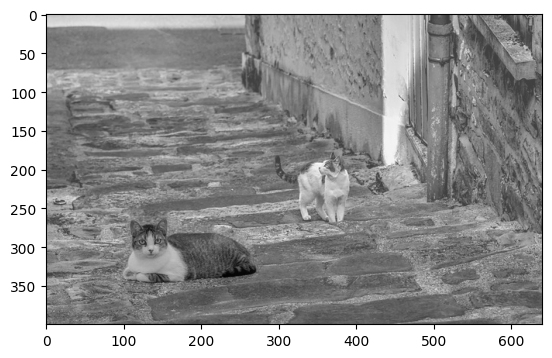

In [440]:
plt.imshow(res_image_gray, cmap='gray')

In [441]:
res_image_r = cloneRegion(src_image[:, :, 0], mask_image, dst_image[:, :, 0], (150, -150))
res_image_g = cloneRegion(src_image[:, :, 1], mask_image, dst_image[:, :, 1], (150, -150))
res_image_b = cloneRegion(src_image[:, :, 2], mask_image, dst_image[:, :, 2], (150, -150))
res_image = dst_image.copy()
res_image[:, :, 0] = res_image_r.clip(0, 1)
res_image[:, :, 1] = res_image_g.clip(0, 1)
res_image[:, :, 2] = res_image_b.clip(0, 1)

True
True
True


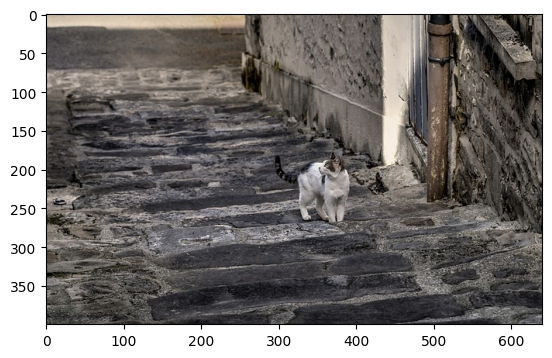

In [442]:
plt.imshow(dst_image)

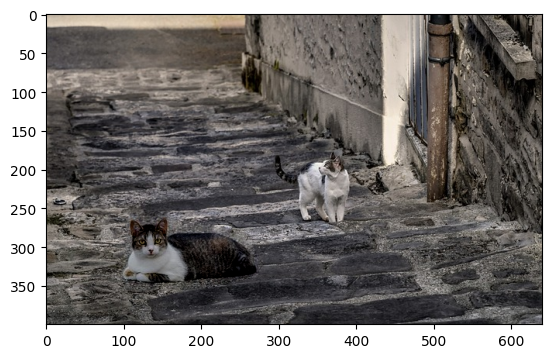

In [443]:
plt.imshow(res_image)

In [461]:
def changeColor(src_image, mask_image, scalars=(1.0, 1.0, 1.0)):
    res_image = src_image.copy()
    height, width, channels = src_image.shape
    for ch in range(channels):
        A, b, idx = constructColorChangeEqn(src_image[:, :, ch], mask_image, scalars[ch])
        csc_A = csc_matrix(A)
        x = spsolve(csc_A, b)
        print(np.allclose(A @ x, b))
        for n, (i, j) in enumerate(idx):
            res_image[i, j, ch] = x[n]

    return res_image.clip(0, 1)

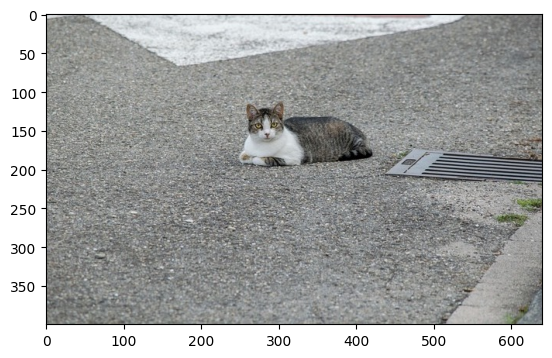

In [463]:
plt.imshow(src_image)

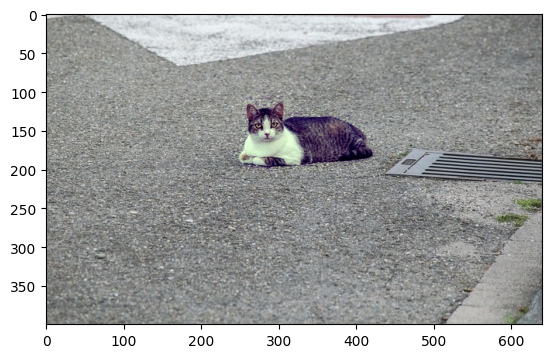

In [464]:
plt.imshow(changeColor(src_image, mask_image, (1.2, 1.5, 0.9)))